# Decoupling analysis
We will try to use EXIOBASE data to detect decoupling between greenhouse gas (GHG) emissions and gross domestic product (GDP) for the various regions in the database. Decoupling can either be relative, whereby the economy grows faster than emissions, or absolute, whereby emissions decrease in volume while the economy keeps growing.

## Preparing
Import the necessary modules...

In [1]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import country_converter as coco
import geopandas
import glob
import pickle
import pint
from scipy.interpolate import interp1d
from sympy import S, symbols, printing

%matplotlib inline

Set a white background for the figures.

In [2]:
sns.set_style('whitegrid')

Where to read/store the EXIOBASE data.

In [3]:
EXIOBASE_PATH = '../EXIOBASE/' # ne pas hésiter à changer

The list of files we will use for the analysis.

In [4]:
files = glob.glob(EXIOBASE_PATH+'IOT_*_ixi.zip')

The indicator we will be looking at (greenhouse gases, but you can choose anything else).

In [5]:
ind = 'Climate change midpoint | ILCD recommended CF | Global warming potential 100 years'

In [6]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)

In [106]:
# Import all the data, careful: this takes forever
if not glob.glob('all_EXIOBASE_impact_data_0.4.pickle'):
    
    data = {}

    for file in files:
        print(file)
        io = mr.parse_exiobase3(path=file)
        year = int(io.meta.description[-4:])
        io.population=pd.DataFrame(columns=['population'],
                                   data=population.loc[year].values,
                                   index=population.columns).T
        io.calc_all()
        data[year] = {'D_cba':io.impacts.D_cba,
                      'D_pba':io.impacts.D_pba,
                      'D_imp':io.impacts.D_imp,
                      'D_exp':io.impacts.D_exp,
                      'D_cba_cap':io.impacts.D_cba_cap,
                      'D_pba_cap':io.impacts.D_pba_cap,
                      'D_imp_cap':io.impacts.D_imp_cap,
                      'D_exp_cap':io.impacts.D_exp_cap,
                      'D_Y':io.impacts.F_Y,
                      'M':io.impacts.M,
                      'Y':io.Y,
                      'x':io.x,
                      'GDP':io.satellite.F.iloc[:9].sum().groupby('region').sum()}
    
    with open('all_EXIOBASE_impact_data_0.4.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open('all_EXIOBASE_impact_data_0.4.pickle', 'rb') as input_file:
        data = pickle.load(input_file)

In [8]:
if not glob.glob('all_EXIOBASE_impact_data_0.4.pickle'):

    # There is a problem with F_Y(2020), CH4 from oil refinery is showing in households
    io2020 = mr.parse_exiobase3(path='../EXIOBASE\\IOT_2020_ixi.zip')

    io2020.impacts.F_Y.loc[ind,(slice(None),'Final consumption expenditure by households')] -= \
        io2020.satellite.F_Y.loc['CH4 - non combustion - Oil refinery - air',
                                 (slice(None),'Final consumption expenditure by households')] * 25

    aaa = \
    io2020.impacts.D_cba.groupby(level="region", axis=1, sort=False).sum() + \
     io2020.impacts.F_Y.groupby(level="region", axis=1, sort=False).sum()

    io2020.impacts.D_cba_reg = aaa

    io2020.impacts.D_cba_cap = aaa/population.loc[year]

    data[2020]['D_Y'] = io2020.impacts.F_Y
    data[2020]['D_cba_reg'] = io2020.impacts.D_cba_reg
    data[2020]['D_cba_cap'] = io2020.impacts.D_cba_cap

    with open('all_EXIOBASE_impact_data_0.4.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [101]:
io.satellite.F_Y['LU'].to_csv('direct_flows_LU_sectors_hh.csv')

In [176]:
ind = 'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'

In [140]:
emissions_totales = io.Z.mul(io.impacts.S.loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'], axis=0)

In [157]:
ordre_pays = emissions_totales['FR'].groupby('region').sum().sum(axis=1).sort_values(ascending=False).index

In [164]:
ordre_pays

Index(['FR', 'WA', 'WF', 'DE', 'WM', 'RU', 'CN', 'ES', 'US', 'BE', 'IT', 'GB',
       'NO', 'PT', 'IN', 'NL', 'WL', 'PL', 'LU', 'TR', 'JP', 'CA', 'AU', 'IE',
       'TW', 'GR', 'WE', 'CH', 'ZA', 'SE', 'CZ', 'RO', 'BR', 'AT', 'MX', 'ID',
       'HU', 'SK', 'KR', 'DK', 'FI', 'BG', 'LT', 'CY', 'HR', 'SI', 'LV', 'EE',
       'MT'],
      dtype='object', name='region')

In [180]:
io.impacts.M.loc[ind]

region  sector                                             
AT      Cultivation of paddy rice                              0.000000e+00
        Cultivation of wheat                                   1.906367e+06
        Cultivation of cereal grains nec                       1.074008e+06
        Cultivation of vegetables, fruit, nuts                 2.991048e+05
        Cultivation of oil seeds                               1.392941e+06
                                                                   ...     
WM      Activities of membership organisation n.e.c. (91)      4.358997e+05
        Recreational, cultural and sporting activities (92)    4.976713e+05
        Other service activities (93)                          5.749196e+05
        Private households with employed persons (95)          2.708904e+05
        Extra-territorial organizations and bodies             0.000000e+00
Name: GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007), Le

In [178]:
io.impacts.S.loc[ind]

region  sector                                             
AT      Cultivation of paddy rice                              0.000000e+00
        Cultivation of wheat                                   1.683871e+06
        Cultivation of cereal grains nec                       9.322016e+05
        Cultivation of vegetables, fruit, nuts                 1.808819e+05
        Cultivation of oil seeds                               1.303135e+06
                                                                   ...     
WM      Activities of membership organisation n.e.c. (91)      1.329557e+04
        Recreational, cultural and sporting activities (92)    9.820782e+03
        Other service activities (93)                          1.249449e+04
        Private households with employed persons (95)          1.012021e+04
        Extra-territorial organizations and bodies             0.000000e+00
Name: GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007), Le

In [181]:
io.A.dot(io.x)

indout
region sector                                                          
AT     Cultivation of paddy rice                               0.000000
       Cultivation of wheat                                  219.451296
       Cultivation of cereal grains nec                      647.892338
       Cultivation of vegetables, fruit, nuts                383.929092
       Cultivation of oil seeds                              141.750318
...                                                                 ...
WM     Activities of membership organisation n.e.c. (91)    2301.393393
       Recreational, cultural and sporting activities ...  12477.275382
       Other service activities (93)                        4802.554883
       Private households with employed persons (95)        2788.347553
       Extra-territorial organizations and bodies              0.000000

[7987 rows x 1 columns]

In [183]:
io.L

In [184]:
io.calc_all()

C:\Users\Gibon\.conda\envs\io\lib\site-packages\pymrio\core\mriosystem.py:878: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  Y_agg = Y.sum(level="region", axis=1).reindex(
C:\Users\Gibon\.conda\envs\io\lib\site-packages\pymrio\core\mriosystem.py:928: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  F_Y_agg = self.F_Y.sum(level="region", axis=1).reindex(


In [195]:
io.A.dot(io.x.sum(axis=1)) + io.Y.sum(axis=1)

region  sector                                             
AT      Cultivation of paddy rice                                  0.000000
        Cultivation of wheat                                     378.272102
        Cultivation of cereal grains nec                         894.025172
        Cultivation of vegetables, fruit, nuts                  1665.261806
        Cultivation of oil seeds                                 175.855935
                                                                   ...     
WM      Activities of membership organisation n.e.c. (91)      22761.213885
        Recreational, cultural and sporting activities (92)    54138.374081
        Other service activities (93)                          31620.402676
        Private households with employed persons (95)           7096.152986
        Extra-territorial organizations and bodies                 0.000000
Length: 7987, dtype: float64

In [196]:
io.L.dot(io.Y.sum(axis=1))

region  sector                                             
AT      Cultivation of paddy rice                                  0.000000
        Cultivation of wheat                                     378.272102
        Cultivation of cereal grains nec                         894.025172
        Cultivation of vegetables, fruit, nuts                  1665.261806
        Cultivation of oil seeds                                 175.855935
                                                                   ...     
WM      Activities of membership organisation n.e.c. (91)      22761.213885
        Recreational, cultural and sporting activities (92)    54138.374081
        Other service activities (93)                          31620.402676
        Private households with employed persons (95)           7096.152986
        Extra-territorial organizations and bodies                 0.000000
Length: 7987, dtype: float64

In [189]:
emissions_totales['FR'].groupby('region').sum().loc[ordre_pays].loc['RU'].sort_values(ascending=False)

sector
Petroleum Refinery                                                                       1.079278e+09
Production of electricity by coal                                                        4.707773e+08
Manufacture of basic iron and steel and of ferro-alloys and first products thereof       4.206563e+08
Sea and coastal water transport                                                          3.649425e+08
Manufacture of gas; distribution of gaseous fuels through mains                          2.799001e+08
                                                                                             ...     
Mining of uranium and thorium ores (12)                                                  0.000000e+00
Extraction, liquefaction, and regasification of other petroleum and gaseous materials    0.000000e+00
Manure treatment (biogas), storage and land application                                  0.000000e+00
Manure treatment (conventional), storage and land application              

In [197]:
io.satellite.unit

,unit
Taxes less subsidies on products purchased: Total,M.EUR
Other net taxes on production,M.EUR
"Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled",M.EUR
"Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled",M.EUR
"Compensation of employees; wages, salaries, & employers' social contributions: High-skilled",M.EUR
...,...
Energy Carrier Net TMAR,TJ
Energy Carrier Net TOTH,TJ
Energy Carrier Net TRAI,TJ
Energy Carrier Net TROA,TJ


## Parse data

In [198]:
sectors = data[2019]['D_pba']['AT'].columns
pd.concat([data[2019]['D_pba'],data[2019]['D_cba']]).groupby('sector',axis=1).sum().T.loc[sectors].to_csv('global_emissions.csv')

In [264]:
io.impacts.D_cba['FR'].to_csv('FR_cba.csv')

In [199]:
(data[2019]['D_cba'] - data[2019]['D_pba']).loc[:,(slice(None),'Production of electricity by coal')]

region,AT,BE,BG,CY,CZ,DE,DK,EE,ES,FI,...,TR,TW,NO,ID,ZA,WA,WL,WE,WF,WM
sector,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,...,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal,Production of electricity by coal
impact,,,,,,,,,,,,,,,,,,,,,
Value Added,8.284371e+01,1.337576e+01,-2.385900e+02,3.838209e-01,1.373908e+02,5.744105e+02,-2.896786e+02,-4.169659e+01,-3.197483e+02,-3.115905e+02,...,-1.043543e+03,-3.538178e+03,2.748779e+00,-4.062645e+02,-2.194280e+03,-1.405309e+03,-2.747875e+02,1.621975e+02,1.492332e+02,-1.349256e+03
Employment,1.091950e+00,2.685440e-01,-7.534215e+00,1.393208e-02,1.439577e+01,8.553397e+01,-8.368983e-01,-7.512970e-01,1.146989e+01,3.563697e+00,...,6.589480e+00,-4.610519e+00,8.577188e-02,2.685513e+01,-4.739019e+01,-1.903329e+02,1.068999e+01,-7.265852e+01,6.967085e+01,-6.048623e-02
Employment hour,2.328875e+06,6.184088e+05,-1.550896e+07,2.958467e+04,2.968834e+07,1.621764e+08,-1.688797e+06,-1.898279e+06,2.375229e+07,7.451792e+06,...,1.739844e+07,-8.890734e+06,1.763021e+05,6.013553e+07,-1.025064e+08,-4.889655e+08,2.515618e+07,-1.847200e+08,1.570529e+08,-5.259462e+06
"GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)",-1.734627e+09,-1.479704e+09,-1.955777e+10,3.479742e+06,-3.820031e+09,-1.121017e+11,2.577568e+07,-5.043866e+09,-4.157123e+10,-1.035269e+09,...,-4.299505e+10,-7.437760e+10,1.984798e+07,-5.644011e+10,-2.644074e+11,-1.669762e+11,-4.389582e+10,-7.667001e+10,-1.143342e+10,-2.161371e+10
"Human toxicity (USEtox) | USEtox2008 | CTUh (Rosenbaum et al., 2008)",-6.319972e+00,6.766818e+00,-4.720329e+02,4.955409e-01,1.721633e+02,5.616244e+03,4.371850e+00,-9.416133e+02,-2.891055e+02,1.298300e+02,...,-5.173762e+03,-3.557455e+02,2.278967e+00,-4.050220e+03,-5.207238e+03,-4.487152e+03,-6.937753e+02,-1.777151e+04,1.443638e+02,3.906804e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Unused Domestic Extraction - Oil and Gas,1.685335e+00,2.844491e-01,1.958209e-01,5.495087e-03,4.967826e+01,5.363241e+01,-1.340432e+01,3.862179e+00,3.583670e+01,1.109628e+01,...,2.956001e+00,6.448134e+00,1.043892e-01,5.166881e+01,7.212503e-02,4.575417e+01,9.865003e+00,2.994056e+01,1.827468e+01,1.186118e+01
Unused Domestic Extraction - Non-metalic Minerals,2.503146e+00,1.430639e+00,1.649583e-01,9.164782e-03,1.281562e+01,3.635640e+02,1.953640e-01,4.021409e+01,4.088511e+01,3.345616e+01,...,7.773407e+00,4.160141e+00,2.079257e-01,1.191246e+01,6.483393e-01,-5.299762e+00,5.956766e+00,1.710449e+01,3.252804e+02,-9.730208e+01


In [200]:
data[2019]['D_Y'].groupby('category',axis=1).sum().T.to_csv('final_cons.csv')

In [201]:
io = mr.parse_exiobase3(path='../EXIOBASE\\IOT_2019_ixi.zip')

In [202]:
io.impacts.unit.to_csv('impact_units.csv')

In [203]:
io.impacts.F_Y.groupby('category',axis=1).sum().T.to_csv('final_cons.csv')

In [204]:
io.impacts.F.loc[ind].sum()

44102440468024.59

In [207]:
years=range(1995,2022)
ref_year=2005
countries=['FR','DE','US']

In [208]:
footprints = pd.concat([v['D_cba'].loc[ind] for v in data.values()],axis=1,keys=data.keys())

In [209]:
GHG_all = {}

for year in years:
    
    try:
        GHG_from_direct = data[year]['D_Y'].loc[ind].unstack().T
        GHG_from_direct.index = pd.MultiIndex.from_product([['DIRECT'],
                                                            GHG_from_direct.index.tolist()])
    except:
        pass

    
    GHG_from_cons = data[year]['Y'].groupby('region',axis=1).sum(1).mul( \
                                data[year]['M'].loc[ind],axis=0).append(GHG_from_direct)
    
    GHG_all[year] = GHG_from_cons
    
GHG_all_df = pd.concat(GHG_all.values(),
                       keys=GHG_all.keys(),
                       names=['year', 'region_origin', 'category'])

In [225]:
GHG_all_df

region                                                                           AT  \
year region_origin category                                                           
1995 AT            Cultivation of paddy rice                           0.000000e+00   
                   Cultivation of wheat                                7.424236e+07   
                   Cultivation of cereal grains nec                    2.518064e+08   
                   Cultivation of vegetables, fruit, nuts              2.857372e+08   
                   Cultivation of oil seeds                            3.500570e+07   
...                                                                             ...   
2021 DIRECT        Exports: Total (fob)                                0.000000e+00   
                   Final consumption expenditure by government         6.748902e+08   
                   Final consumption expenditure by households         1.330823e+10   
                   Final consumption expenditure by non-profit org...  4.952117e+08   
                   Gross fixed capital formation                       0.000000e+00   

region                                                                           AU  \
year region_origin category                                                           
1995 AT            Cultivation of paddy rice                           0.000000e+00   
                   Cultivation of wheat                                1.804011e+04   
                   Cultivation of cereal grains nec                    2.140419e+04   
                   Cultivation of vegetables, fruit, nuts              4.439886e-05   
                   Cultivation of oil seeds                            9.080428e-05   
...                                                                             ...   
2021 DIRECT        Exports: Total (fob)                                0.000000e+00   
                   Final consumption expenditure by government         1.983252e+09   
                   Final consumption expenditure by households         3.744995e+10   
                   Final consumption expenditure by non-profit org...  1.056745e+09   
                   Gross fixed capital formation                       0.000000e+00   

region                                                                           BE  \
year region_origin category                                                           
1995 AT            Cultivation of paddy rice                           0.000000e+00   
                   Cultivation of wheat                                1.672995e+04   
                   Cultivation of cereal grains nec                    3.803800e+04   
                   Cultivation of vegetables, fruit, nuts              3.504340e+05   
                   Cultivation of oil seeds                            2.919844e+05   
...                                                                             ...   
2021 DIRECT        Exports: Total (fob)                                0.000000e+00   
                   Final consumption expenditure by government         2.015117e+09   
                   Final consumption expenditure by households         2.714314e+10   
                   Final consumption expenditure by non-profit org...  1.128555e+09   
                   Gross fixed capital formation                       0.000000e+00   

region                                                                           BG  \
year region_origin category                                                           
1995 AT            Cultivation of paddy rice                           0.000000e+00   
                   Cultivation of wheat                                7.928801e+00   
                   Cultivation of cereal grains nec                    9.407342e+00   
                   Cultivation of vegetables, fruit, nuts              3.604950e+03   
                   Cultivation of oil seeds                            1.656794e+0

In [233]:
liste_emissions_FR = GHG_all_df.loc[2019]['FR'].sort_values(ascending=False).reset_index()

In [234]:
liste_emissions_FR

,region_origin,category,FR
0,FR,Construction (45),6.849675e+10
1,DIRECT,Final consumption expenditure by households,6.214190e+10
2,FR,Public administration and defence; compulsory ...,2.102149e+10
3,FR,Air transport (62),1.820874e+10
4,FR,Health and social work (85),1.614001e+10
...,...,...,...
7989,JP,Re-processing of secondary construction materi...,0.000000e+00
7990,JP,"Sale, maintenance, repair of motor vehicles, m...",0.000000e+00
7991,JP,Retail sale of automotive fuel,0.000000e+00
7992,JP,"Retail trade, except of motor vehicles and mot...",0.000000e+00


In [239]:
liste_emissions_FR[liste_emissions_FR.region_origin != 'FR'].iloc[:40]

,region_origin,category,FR
1,DIRECT,Final consumption expenditure by households,6.214190e+10
18,DIRECT,Final consumption expenditure by government,7.115257e+09
24,DE,"Manufacture of motor vehicles, trailers and se...",4.253176e+09
26,DIRECT,Final consumption expenditure by non-profit or...,4.039506e+09
33,ES,"Manufacture of motor vehicles, trailers and se...",3.269025e+09
38,WF,"Manufacture of motor vehicles, trailers and se...",2.608889e+09
41,CN,Manufacture of wearing apparel; dressing and d...,2.420241e+09
46,CN,Manufacture of furniture; manufacturing n.e.c....,2.110058e+09
49,CN,"Manufacture of radio, television and communica...",2.042920e+09
52,CN,Manufacture of office machinery and computers ...,1.923295e+09


In [211]:
GHG_cba_w_direct = GHG_all_df.groupby('year').sum()

In [212]:
GHG_cons_by_origin=GHG_all_df.groupby(['year','region_origin']).sum().unstack(0)
GHG_cons_by_sector=GHG_all_df.groupby(['year','category']).sum().unstack(0)

In [213]:
pop=population.unstack()
pop.index.names=['region','year']

In [214]:
GHG_cons_by_origin_cap = GHG_cons_by_origin/pop
GHG_cons_by_sector_cap = GHG_cons_by_sector/pop

C:\Users\Gibon\.conda\envs\io\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


(1995.0, 2021.0)

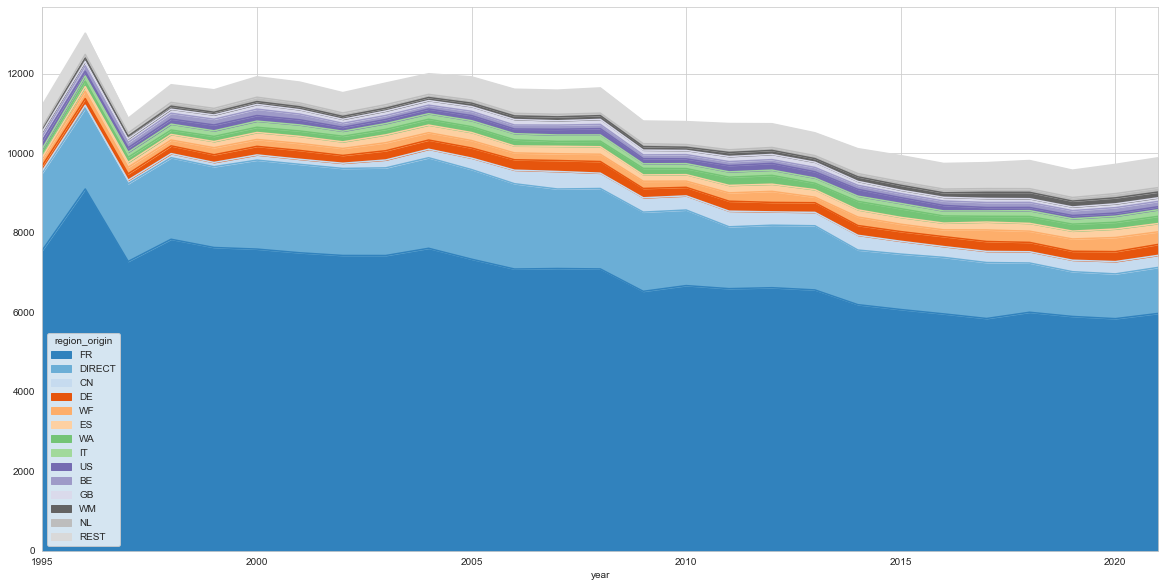

In [251]:
c = 'FR'
t = .95
df = GHG_cons_by_origin_cap

cumul = df[c].sum(1)
GHG_cut = (cumul/cumul.sum()).sort_values(ascending=False).cumsum()

GHG_to_plot = df.loc[GHG_cut<t]
GHG_to_plot.loc['REST'] = df.loc[GHG_cut>=t].sum()
order = GHG_cut.index[GHG_cut<t].tolist() + ['REST']

ax = GHG_to_plot.loc[order][c].T.plot.area(stacked=True,
                                           figsize=(20,10),
                                           cmap='tab20c')
ax.set_xlim((years[0],years[-1]))

In [ ]:
# There is a "value added" row in the impact matrix, let's see if it matches calculated GDP...
gdp1 = data[ref_year]['D_cba']['FR'].loc['Value Added'].sum()
gdp2 = data[ref_year]['GDP']['FR']
print(gdp1, gdp2)

In [250]:
data[2019]['D_Y']

region                                                                                      AT  \
category                                           Final consumption expenditure by households   
impact                                                                                           
Value Added                                                                       0.000000e+00   
Employment                                                                        0.000000e+00   
Employment hour                                                                   0.000000e+00   
GHG emissions (GWP100) | Problem oriented appro...                                1.423881e+10   
Human toxicity (USEtox) | USEtox2008 | CTUh (Ro...                                1.809445e+02   
...                                                                                        ...   
Unused Domestic Extraction - Oil and Gas                                          0.000000e+00   
Unused Domestic Extraction - Non-metalic Minerals                                 0.000000e+00   
Unused Domestic Extraction - Iron Ore                                             0.000000e+00   
Unused Domestic Extraction - Non-ferous metal ores                                0.000000e+00   
Land use Crop, Forest, Pasture                                                    3.593989e+03   

region                                                                                                                                   \
category                                           Final consumption expenditure by non-profit organisations serving households (NPISH)   
impact                                                                                                                                    
Value Added                                                                              0.000000e+00                                     
Employment                                                                               0.000000e+00                                     
Employment hour                                                                          0.000000e+00                                     
GHG emissions (GWP100) | Problem oriented appro...                                       5.922743e+08                                     
Human toxicity (USEtox) | USEtox2008 | CTUh (Ro...                                       8.657653e-01                                     
...                                                                                               ...                                     
Unused Domestic Extraction - Oil and Gas                                                 0.000000e+00                                     
Unused Domestic Extraction - Non-metalic Minerals                                        0.000000e+00                                     
Unused Domestic Extraction - Iron Ore                                                    0.000000e+00                                     
Unused Domestic Extraction - Non-ferous metal ores                                       0.000000e+00                                     
Land use Crop, Forest, Pasture                                                           0.000000e+00                                     

region                                                                                          \
category                                           Final consumption expenditure by government   
impact                                                                                           
Value Added                                                                       0.000000e+00   
Employment                                                                        0.000000e+00   
Employment hour                                                                   0.000000e+00   
GHG emissions (GWP100) | Problem oriented appro...                                7.515299e+

In [18]:
list(data[year]['D_cba'].index)

['Value Added',
 'Employment',
 'Employment hour',
 'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)',
 'Human toxicity (USEtox) | USEtox2008 | CTUh (Rosenbaum et al., 2008)',
 'Fresh water Ecotoxicity (USEtox) | USEtox2008 | CTUe (Rosenbaum et al., 2008)',
 'EPS | Damage Approach | EPS (Steen, 1999))',
 'Carcinogenic effects on humans (H.A) | ECOINDICATOR 99 (H.A) | Carcinogenic effects on humans (H.A)',
 'Respiratory effects on humans caused by organic substances (H.A) | ECOINDICATOR 99 (H.A) | Respiratory effects on humans caused by organic substances (H.A)',
 'Respiratory effects on humans caused by inorganic substances (H.A) | ECOINDICATOR 99 (H.A) | Respiratory effects on humans caused by inorganic substances (H.A)',
 'Damages to human health caused by climate change (H.A) | ECOINDICATOR 99 (H.A) | Damages to human health caused by climate change (H.A)',
 'Damage to Ecosystem Quality caused by ecotoxic emissions (H.A) | ECOINDICATOR 

In [19]:
ind='Particulate matter/Respiratory inorganics endpoint | ILCD recommended CF | Disability Adjusted Life Years (DALY)'
ind= 'Climate change midpoint | ILCD recommended CF | Global warming potential 100 years',

In [20]:
GDPs = dict()
GHGs_cba = dict()
GHGs_pba = dict()
GHGs_cba_cap = dict()
GHGs_pba_cap = dict()

for year in years:
    GDPs[year] = data[year]['GDP']
    GHGs_cba[year] = data[year]['D_cba'].loc[ind].groupby('region').sum()
    GHGs_pba[year] = data[year]['D_pba'].loc[ind].groupby('region').sum()
    GHGs_cba_cap[year] = data[year]['D_cba_cap'].loc[ind]
    GHGs_pba_cap[year] = data[year]['D_pba_cap'].loc[ind]

In [21]:
GDPs_df = pd.DataFrame(GDPs).T
# GHGs_cba_df = pd.DataFrame(GHGs_cba).T
GHGs_cba_df = GHG_cba_w_direct
GHGs_pba_df = pd.DataFrame(GHGs_pba).T
GHGs_cba_cap_df = pd.DataFrame(GHGs_cba_cap).T
GHGs_pba_cap_df = pd.DataFrame(GHGs_pba_cap).T

In [22]:
GHG_comp = pd.concat([
    GHGs_pba_df.div(GHGs_pba_df.loc[ref_year]),
    GHGs_cba_df.div(GHGs_cba_df.loc[ref_year])
], keys=('territorial', 'footprint'), axis=1).sort_index(axis=1)

In [23]:
f1 = interp1d(GHG_comp.index, GHG_comp,kind='cubic',axis=0)

new_index = np.arange(years[0],years[-1],0.1)
GHG_comp_smooth = pd.DataFrame(f1(new_index), columns=GHG_comp.columns)
GHG_comp_smooth.index = new_index

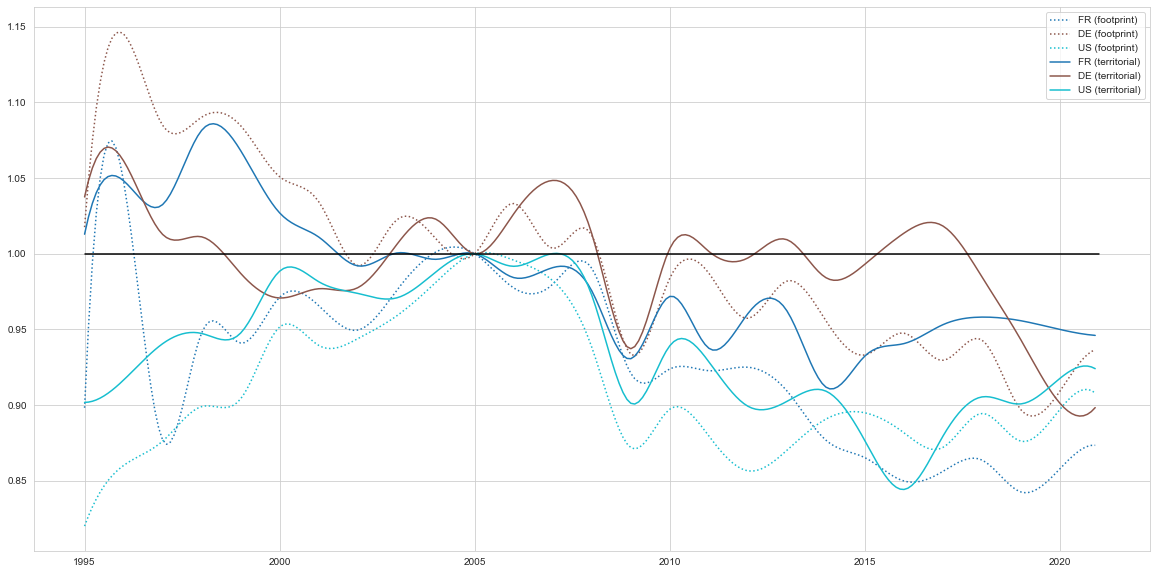

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
GHG_comp_smooth['footprint'][countries].plot(cmap='tab10', ax=ax, linestyle=':')
GHG_comp_smooth['territorial'][countries].plot(cmap='tab10', ax=ax, linestyle='-')
plt.legend([f'{c} ({scope})' for scope in ['footprint','territorial'] for c in countries])
ax.plot([years[0], years[-1]], [1, 1], color='black')

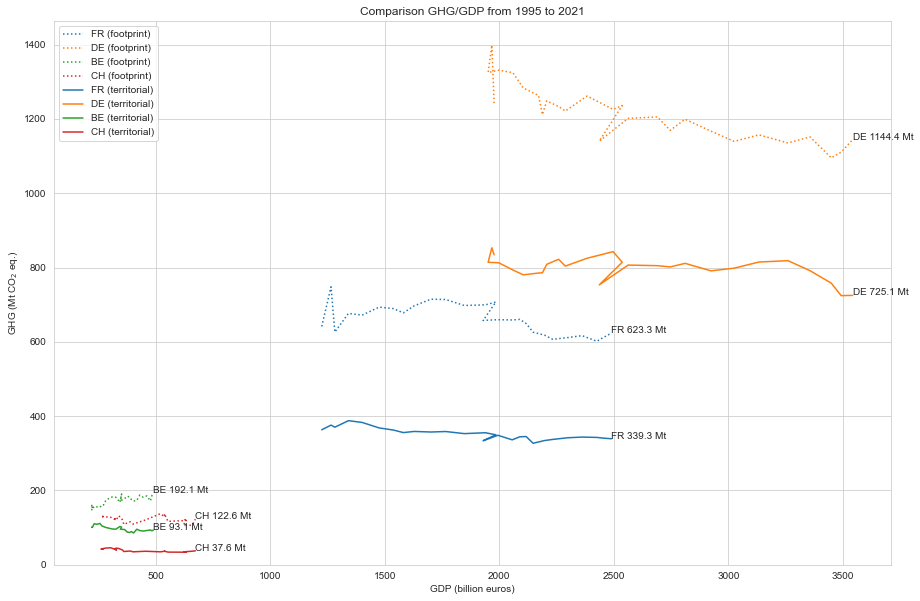

In [25]:
# National GDP/GHG emissions 

regions = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'GB', 'US', 'JP', 'CN', 'CA', 'KR', 'BR', 'IN', 'MX',
       'RU', 'AU', 'CH', 'TR', 'TW', 'NO', 'ID', 'ZA', 'WA', 'WL', 'WE', 'WF',
       'WM']
regions = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'GB']
regions = ['FR','DE','BE','CH']
fig, ax = plt.subplots(figsize=(15,10))

# scales
s = (1e-3, 1e-9)

ax.plot(GDPs_df[regions]*s[0],
        GHGs_cba_df[regions]*s[1],
       linestyle=':')

colors = [l.get_color() for l in ax.get_lines()]

ax.set_xlabel('GDP (billion euros)')
ax.set_ylabel('GHG (Mt CO$_{2}$ eq.)')
ax.set_ylim(0,)

for i,c in enumerate(regions):
    gdp  = GDPs_df[c].iloc[-1]*s[0]
    ghgc = GHGs_cba_df[c].iloc[-1]*s[1]
    ghgp = GHGs_pba_df[c].iloc[-1]*s[1]
    
    ax.annotate(f'{c} {ghgc:.1f} Mt', (gdp, ghgc))
    ax.annotate(f'{c} {ghgp:.1f} Mt', (gdp, ghgp))
    
    ax.plot(GDPs_df[c]*s[0],
        GHGs_pba_df[c]*s[1],
            color=colors[i])

ax.set_title(f'Comparison GHG/GDP from {years[0]} to {years[-1]}')
labels=[f'{r} ({scope})' for scope in ['footprint','territorial'] for r in regions]
plt.legend(labels=labels)

In [53]:
GDPs_cap_df = (GDPs_df/population*1e6).dropna()
GDPs_cap_df['WORLD'] = (GDPs_df.sum(1)/population.sum(1)*1e6).dropna()
GDPs_cap_df['EU27+1'] = (GDPs_df[GHGs_cba_cap_df.columns[:28]].sum(1)/population.iloc[:,:28].sum(1)*1e6).dropna()

In [54]:
# GHGs_cba_cap_df = (GHGs_cba_df/population).dropna()

GHGs_cba_cap_df['WORLD'] = (GHGs_cba_df.sum(1)/population.sum(1)).dropna()
# The proper way to account for per-cap consumption at the EU level would be to aggregate the IO tables themselves
# GHGs_cba_cap_df['EU27+1'] = (GHGs_cba_df.iloc[:,:28].sum(1)/population.iloc[:,:28].sum(1)).dropna()

# We take a shortcut for the sake of simplicity
GHGs_cba_cap_df['EU27+1'] = (GHGs_cba_cap_df.iloc[:,:28] * population.iloc[:,:28].div(
    population.iloc[:,:28].sum(1),
    axis=0)).sum(1)

GHGs_pba_cap_df = (GHGs_pba_df/population).dropna()
GHGs_pba_cap_df['WORLD'] = (GHGs_pba_df.sum(1)/population.sum(1)).dropna()
GHGs_pba_cap_df['EU27+1'] = (GHGs_pba_df.iloc[:,:28].sum(1)/population.iloc[:,:28].sum(1)).dropna()


In [55]:
regions = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'GB', 'US', 'JP', 'CN', 'CA', 'KR', 'BR', 'IN', 'MX',
       'RU', 'AU', 'CH', 'TR', 'TW', 'NO', 'ID', 'ZA', 'WA', 'WL', 'WE', 'WF',
       'WM']
world = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'GB', 'EU27+1', 'US', 'JP', 'CN', 'CA', 'KR', 'BR', 'IN', 'MX',
       'RU', 'AU', 'CH', 'TR', 'TW', 'NO', 'ID', 'ZA', 'WA', 'WL', 'WE', 'WF',
       'WM','WORLD']
world_labels = coco.convert(names=regions[:-5], to = 'name_short', not_found=None) + regions[-5:] + ['WORLD']

regions = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'GB']
regions = ['FR',
#            'DE',
           'GB']

In [56]:
# Per capita GDP/GHG emissions 


def plot_decoupling(regions,
                    X=GDPs_cap_df,
                    Y1=GHGs_cba_cap_df,
                    Y2=GHGs_pba_cap_df,
                    scale=(1,1e-3),
                    mark_years=[1995,2021],
                   territorial=True):

    fig, ax = plt.subplots(figsize=(15,10))

    # scales
    s = scale
    alpha_min = 0.1
    
    # first line to get colors, with minimum transparency
    ax.plot(X.loc[years[0]:years[0]+1,regions]*s[0],
           Y1.loc[years[0]:years[0]+1,regions]*s[1],
           linestyle=':',
           alpha=alpha_min)
    
    # get the colors
    colors = [l.get_color() for l in ax.get_lines()]

    # make the lines with decreasing transparency
    for i,year in enumerate(years[:-1]):
        for j,c in enumerate(regions):
            ax.plot(X.loc[year:year+1,c]*s[0],
                   Y1.loc[year:year+1,c]*s[1],
                   linestyle=':',
                   alpha=alpha_min + (1-alpha_min)*(i/(years[-1]-years[0]))**2,
                   color=colors[j])

    # make a dark line for world
    if 'WORLD' in regions:
        ax.plot(X['WORLD']*s[0],
            Y1['WORLD']*s[1],
           linestyle='-',
           linewidth=2,
           alpha=1,
           color='#000000')
    if 'EU27+1' in regions:
        ax.plot(X['EU27+1']*s[0],
            Y1['EU27+1']*s[1],
           linestyle='-',
           linewidth=2,
           alpha=1,
           color='#000000')
    
    # labels etc.
    ax.set_xlabel('Per-capita GDP (euros)')
    ax.set_ylabel('Per-capita GHG emissions (t CO$_{2}$ eq./cap)')
    ax.set_xlim(0,)
    ax.set_ylim(0,)

    for i,c in enumerate(regions):

        gdp  = X[c].iloc[-1]*s[0]
        ghgc = Y1[c].iloc[-1]*s[1]
        ghgp = Y2[c].iloc[-1]*s[1]
    
        ax.scatter(X[c].iloc[-1]*s[0],
          Y1[c].iloc[-1]*s[1],
          color=colors[i])
       
        if territorial:
            ax.annotate(f'{c} footprint', (gdp+500, ghgc), ha='left' ,va='center')
            ax.annotate(f'{c} territorial', (gdp+500, ghgp), ha='left' ,va='center')

            ax.plot(X[c]*s[0],
                Y2[c]*s[1],
                    color=colors[i],
                   alpha=0.5)

        else:
            if i<43 and c!='EU27+1':
                ax.annotate(coco.convert(c,
                                         to='name_short'),
                            (gdp+500, ghgc),
                            ha='left',
                            va='center')
            else:
                ax.annotate(c,
                            (gdp+500, ghgc),
                            ha='left',
                            va='center')
                
        if mark_years:

            ax.scatter(X.loc[mark_years[1:],c]*s[0],
                  Y1.loc[mark_years[1:],c]*s[1],
                      color=colors[i])

            for y in [1995,2021]:
                ax.annotate(f'{y}\n{Y1.loc[y,c]*s[1]:.1f} t',
                            (X.loc[y,c]*s[0],
                            Y1.loc[y,c]*s[1]+.2),
                           ha='center')

            y1=1995
            y2=2021

            ax.arrow(X.loc[y1,c]*s[0],
                     Y1.loc[y1,c]*s[1],
                     (X.loc[y2,c] - X.loc[y1,c])*s[0],
                     (Y1.loc[y2,c] - Y1.loc[y1,c])*s[1],
                     color=colors[i],
                    alpha=0.5)

#             y1=1995
#             y2=2021

#             ax.arrow(X.loc[y1,c]*s[0],
#                      Y1.loc[y1,c]*s[1],
#                      (X.loc[y2,c] - X.loc[y1,c])*s[0],
#                      (Y1.loc[y2,c] - Y1.loc[y1,c])*s[1],
#                      color=colors[i])

        ax.set_title(f'Comparison GHG/GDP from {years[0]} to {years[-1]}')
    if territorial:
        labels=[f'{r} ({scope})' for scope in ['footprint','territorial'] for r in regions]
    else:
        labels=[f'{r} (footprint, per capita)' for r in regions]
#     plt.legend(labels=labels)
    plt.tight_layout()

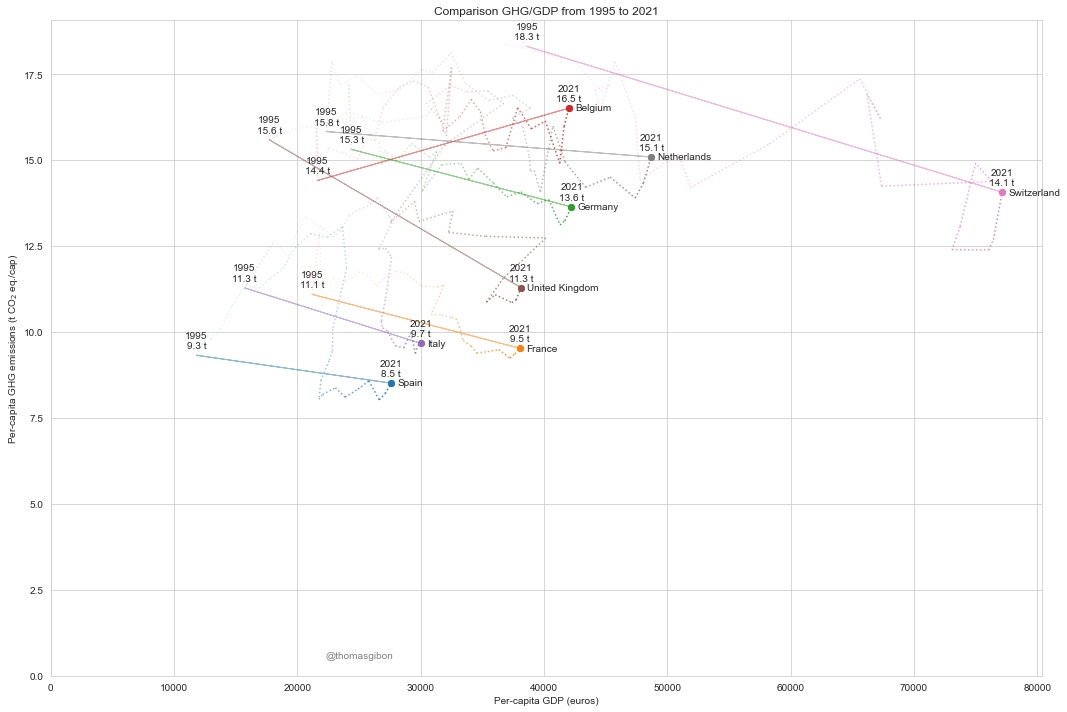

In [57]:
plot_decoupling(['ES','FR','DE','BE','IT','GB','CH','NL'],
#                 mark_years=None,
               territorial=False,
               scale=(1,1e-3))
plt.annotate('@thomasgibon',xy=(25000,.5),ha='center',color='grey')
plt.savefig('GHG_GDP_select_r.svg')

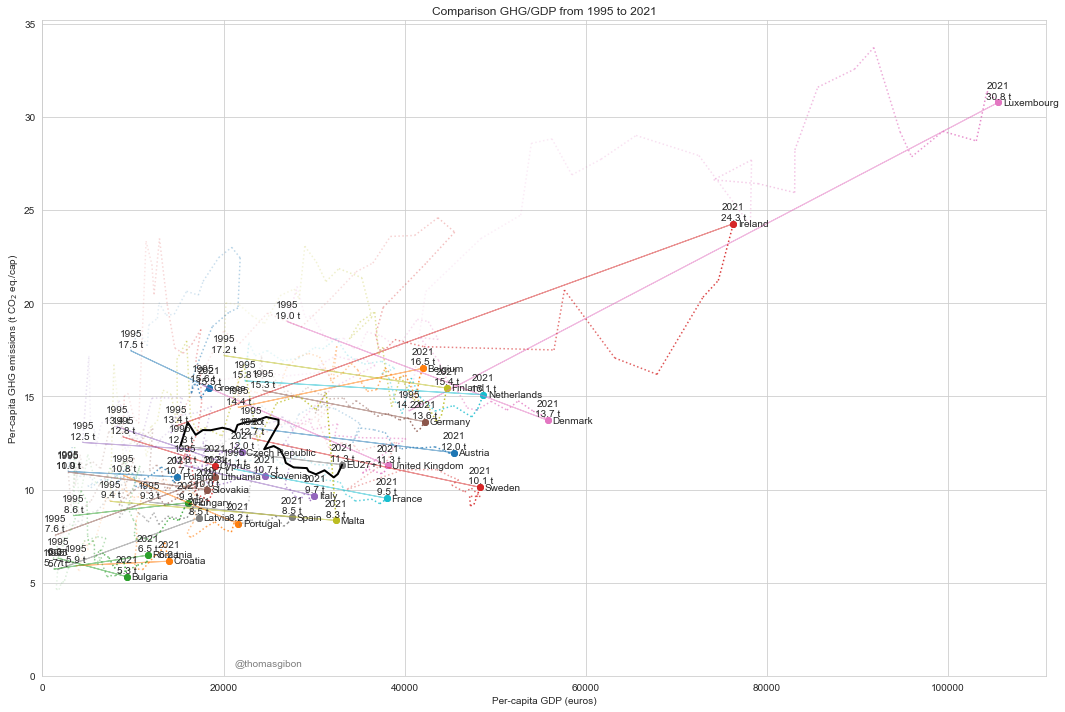

In [58]:
plot_decoupling([r for r in world[:29] if r != 'EE'],
#                 mark_years=None,
               territorial=False,
               scale=(1,1e-3))
plt.annotate('@thomasgibon',xy=(25000,.5),ha='center',color='grey')
plt.savefig('GHG_GDP_mark_years.svg')

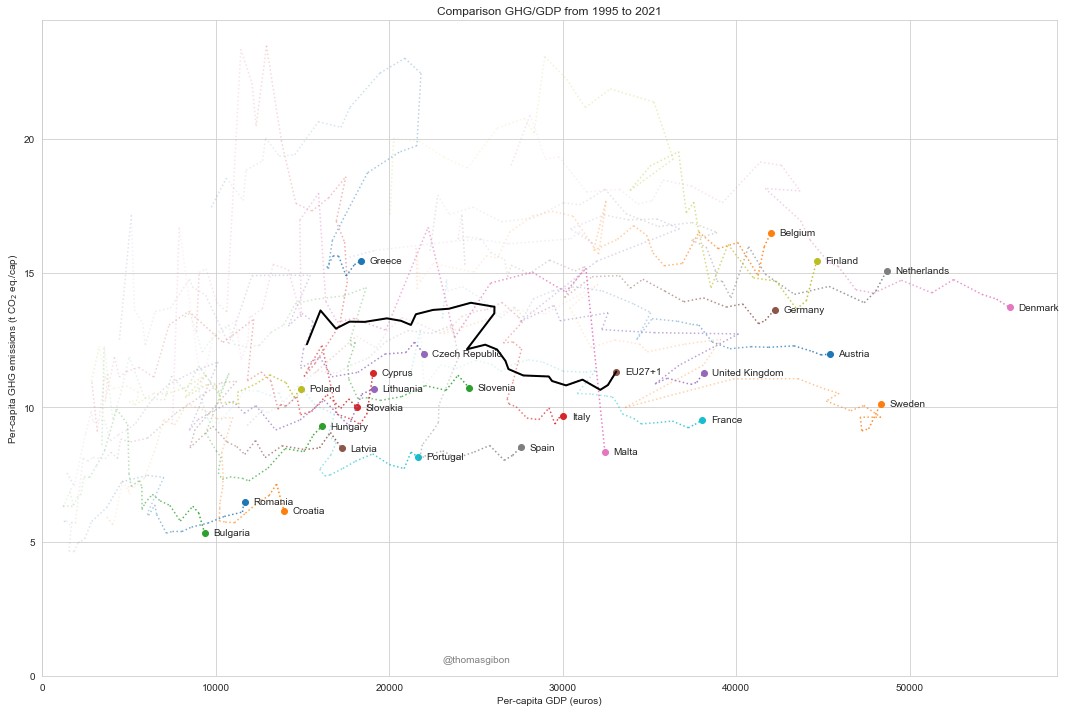

In [59]:
plot_decoupling([r for r in world[:29] if r not in ['IE','LU','EE']],
                mark_years=None,
               territorial=False,
               scale=(1,1e-3))
plt.annotate('@thomasgibon',xy=(25000,.5),ha='center',color='grey')
plt.savefig('GHG_GDP.svg')

### Regression attempts

In [60]:
data[2019]['D_Y']['FR'].loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']

category
Final consumption expenditure by households                                             6.214190e+10
Final consumption expenditure by non-profit organisations serving households (NPISH)    4.039506e+09
Final consumption expenditure by government                                             7.115257e+09
Gross fixed capital formation                                                           0.000000e+00
Changes in inventories                                                                  0.000000e+00
Changes in valuables                                                                    0.000000e+00
Exports: Total (fob)                                                                    0.000000e+00
Name: GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007), dtype: float64

In [61]:
FR_imports=io.Z['FR'].stack().unstack(0).sort_values(by='FR',ascending=False)
FR_imports.index.names = ['sector_from', 'sector_to']

NameError: name 'io' is not defined

In [62]:
FR_imports[FR_imports.sum(1)>5000]

NameError: name 'FR_imports' is not defined

In [63]:
FR_imports[FR_imports.sum(1)>10000].plot.bar(figsize=(20,10),stacked=True, cmap='viridis')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=10)

NameError: name 'FR_imports' is not defined

In [64]:
FR_imports = io.Z['FR'].groupby('region').sum().unstack().sort_values(ascending=False)

NameError: name 'io' is not defined

In [ ]:
FR_imports[FR_imports.index.get_level_values(1) != 'FR']

In [ ]:
io.satellite.F_Y[io.satellite.F_Y.sum(1)!=0]['FR']

In [ ]:
np.array([regions]*2).T.flatten()

In [65]:
def regression(regions, order=2):
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    for i,r in enumerate(regions):
        x = GDPs_cap_df[r]
        y = GHGs_cba_cap_df[r]
        z = np.polyfit(x, y, order)
        p = np.poly1d(z)
        xx = np.linspace(15000,45000,1000)
        ax.plot(x, y, '.', label=r)
        
        color = ax.get_lines()[2*i].get_color()
        
        x = symbols("x")
        poly = sum(S("{:.2e}".format(v))*x**i for i, v in enumerate(z[::-1]))
        eq_latex = printing.latex(poly)
        
        ax.plot(xx, p(xx), '-', color=color, label="${}$".format(eq_latex))
        
        
#     plt.legend(np.array([regions]*2).T.flatten())
    plt.legend(fontsize="small")
    ax.set_xlabel('Per-capita GDP (euros)')
    ax.set_ylabel('Per-capita GHG emissions (t CO$_{2}$ eq./cap)')
    plt.show()


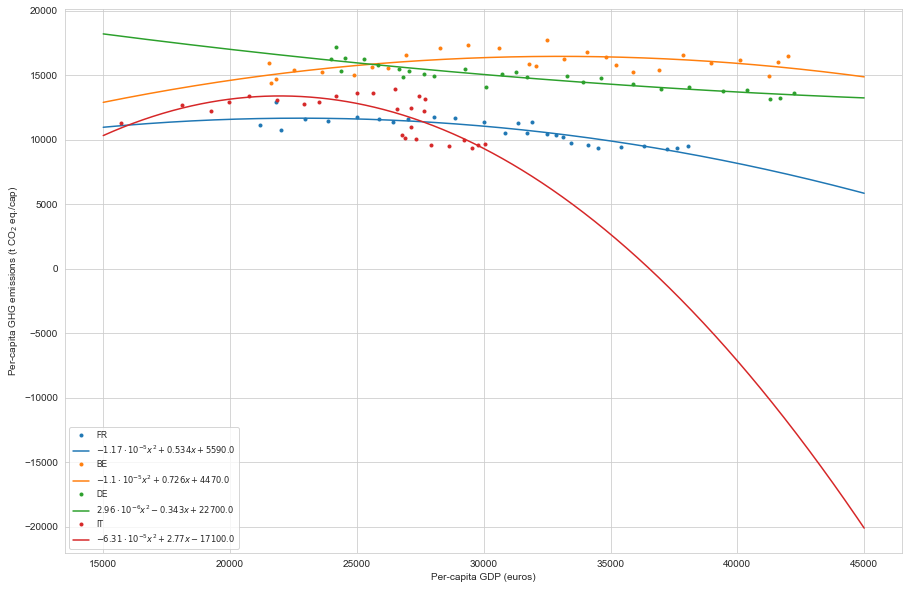

In [66]:
regression(['FR','BE','DE', 'IT'])

In [67]:
ghg1, ghg2 = np.meshgrid(GHGs_cba_cap_df['BE'], GHGs_cba_cap_df['BE'])
gdp1, gdp2 = np.meshgrid(GDPs_cap_df['BE'], GDPs_cap_df['BE'])

In [68]:
variations=pd.DataFrame((ghg1-ghg2)/(gdp1-gdp2), index=GHGs_cba_cap_df.index, columns=GHGs_cba_cap_df.index)

<ipython-input-68-a30ee177c3f6>:1: RuntimeWarning: invalid value encountered in true_divide
  variations=pd.DataFrame((ghg1-ghg2)/(gdp1-gdp2), index=GHGs_cba_cap_df.index, columns=GHGs_cba_cap_df.index)


In [69]:
for v in variations:
    i=variations[v].argmin()
    print(v, variations.index[i], variations[v].iloc[i])

1995 1996 -19.6425863911685
1996 1995 -19.6425863911685
1997 1996 -4.935085381224643
1998 1996 -0.5818132819275667
1999 1996 -0.34541679596374325
2000 1996 -0.26749925162146204
2001 2002 -0.13804939554030454
2002 2001 -0.13804939554030454
2003 2007 -0.15829304478028955
2004 2007 -0.37483119876631404
2005 2009 -0.6109644866408829
2006 2009 -1.0833205841675955
2007 2006 -0.9581724217178584
2008 2010 -2.1493098863632705
2009 2006 -1.0833205841675955
2010 2008 -2.1493098863632705
2011 2013 -0.910393394360138
2012 2013 -1.7829318833748755
2013 2012 -1.7829318833748755
2014 2012 -1.1093131882262657
2015 2008 -0.5294992413378443
2016 2017 -0.5546799682727964
2017 2016 -0.5546799682727964
2018 2019 -1.0503506786664862
2019 2018 -1.0503506786664862
2020 2008 -0.18754684700287236
2021 2008 -0.12401399003882757


In [70]:
GHG_intensity = GHGs_cba_cap_df/GDPs_cap_df

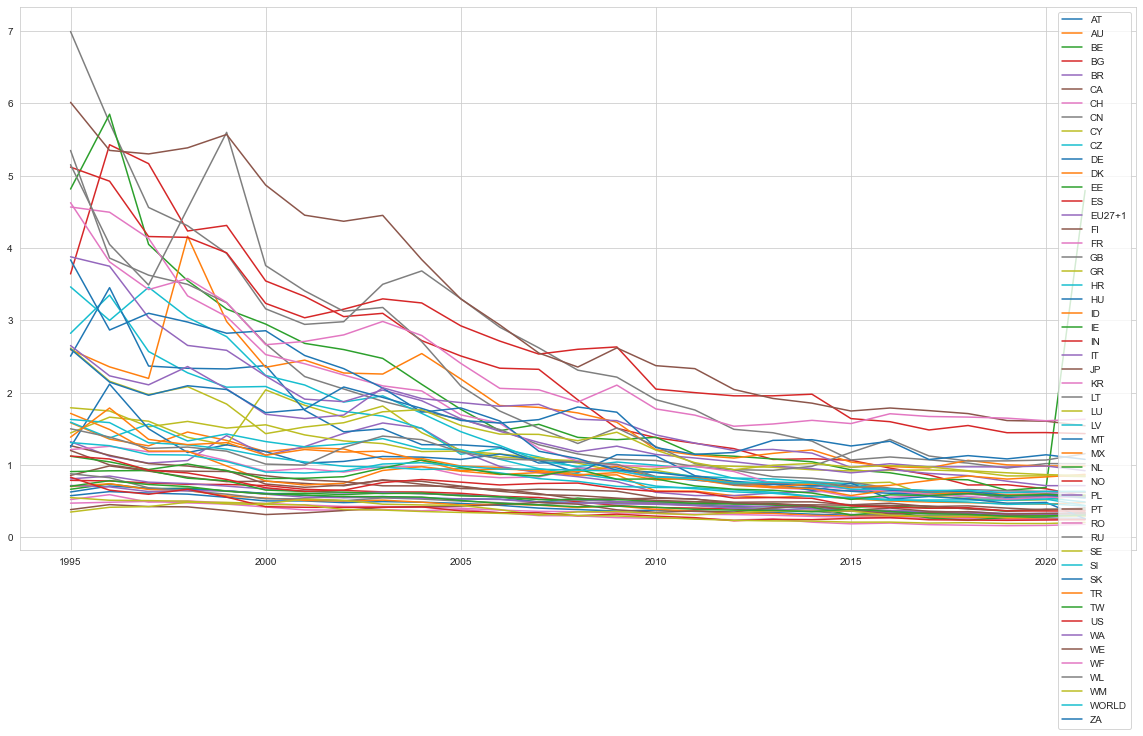

In [82]:
GHG_intensity.plot(figsize=(20,10))

In [71]:
decade_var=pd.DataFrame(GHG_intensity.iloc[:-10].values - GHG_intensity.iloc[10:].values,
             columns=GHG_intensity.columns,
            index=GHG_intensity.index[:-10])

In [72]:
# Relative decoupling
for c in decade_var:
    start=decade_var[c].argmax()
    start_year=decade_var.index[start]
    value=decade_var.loc[start_year,c]
    print(f'''{c} went from ({GHGs_cba_cap_df.loc[start_year,c]/1000:.1f} t/cap \
with {GDPs_cap_df.loc[start_year,c]:.0f}€/cap)
          to ({GHGs_cba_cap_df.loc[start_year+10,c]/1000:.1f} t/cap \
with {GDPs_cap_df.loc[start_year+10,c]:.0f}€/cap) between {start_year} and {start_year+10}
''')

AT went from (14.5 t/cap with 24211€/cap)
          to (13.5 t/cap with 35072€/cap) between 1998 and 2008

AU went from (29.0 t/cap with 23721€/cap)
          to (31.2 t/cap with 54056€/cap) between 2002 and 2012

BE went from (14.7 t/cap with 21796€/cap)
          to (15.7 t/cap with 32077€/cap) between 1997 and 2007

BG went from (6.3 t/cap with 1168€/cap)
          to (8.4 t/cap with 3588€/cap) between 1996 and 2006

BR went from (4.3 t/cap with 2718€/cap)
          to (5.7 t/cap with 9262€/cap) between 2003 and 2013

CA went from (20.2 t/cap with 15885€/cap)
          to (20.8 t/cap with 29318€/cap) between 1995 and 2005

CH went from (17.9 t/cap with 45761€/cap)
          to (14.4 t/cap with 76275€/cap) between 2005 and 2015

CN went from (3.2 t/cap with 453€/cap)
          to (4.6 t/cap with 1381€/cap) between 1995 and 2005

CY went from (23.3 t/cap with 11439€/cap)
          to (16.2 t/cap with 17423€/cap) between 2000 and 2010

CZ went from (17.2 t/cap with 5128€/cap)
         

In [73]:
# Absolute decoupling
decade_var=pd.DataFrame(GHGs_cba_cap_df.iloc[:-10].values - GHGs_cba_cap_df.iloc[10:].values,
             columns=GHGs_cba_cap_df.columns,
            index=GHGs_cba_cap_df.index[:-10])

for c in decade_var:
    start=decade_var[c].argmax()
    start_year=decade_var.index[start]
    value=decade_var.loc[start_year,c]
    print(f'''{c} went from ({GHGs_cba_cap_df.loc[start_year,c]/1000:.1f} t/cap \
with {GDPs_cap_df.loc[start_year,c]:.0f}€/cap)
          to ({GHGs_cba_cap_df.loc[start_year+10,c]/1000:.1f} t/cap \
with {GDPs_cap_df.loc[start_year+10,c]:.0f}€/cap) between {start_year} and {start_year+10}
''')

AT went from (14.5 t/cap with 30770€/cap)
          to (12.2 t/cap with 39651€/cap) between 2005 and 2015

BE went from (17.3 t/cap with 29384€/cap)
          to (15.4 t/cap with 36901€/cap) between 2005 and 2015

BG went from (9.9 t/cap with 4276€/cap)
          to (6.3 t/cap with 7348€/cap) between 2007 and 2017

CY went from (23.5 t/cap with 12922€/cap)
          to (11.6 t/cap with 15726€/cap) between 2003 and 2013

CZ went from (14.9 t/cap with 12084€/cap)
          to (11.1 t/cap with 16698€/cap) between 2006 and 2016

DE went from (16.3 t/cap with 25294€/cap)
          to (14.1 t/cap with 30110€/cap) between 1999 and 2009

DK went from (19.0 t/cap with 42609€/cap)
          to (14.3 t/cap with 51289€/cap) between 2007 and 2017

EE went from (19.1 t/cap with 12183€/cap)
          to (14.6 t/cap with 18087€/cap) between 2007 and 2017

ES went from (13.1 t/cap with 23644€/cap)
          to (8.3 t/cap with 24907€/cap) between 2007 and 2017

FI went from (21.2 t/cap with 31303€/cap)


In [103]:
(data[2016]['D_cba'].loc[ind,'SK']-data[2006]['D_cba'].loc[ind,'SK']).loc[ind].sort_values()

sector
Extraction of natural gas and services related to natural gas extraction, excluding surveying         -1.722233e+10
Construction (45)                                                                                     -2.403097e+09
Steam and hot water supply                                                                            -1.875525e+09
Real estate activities (70)                                                                           -9.067798e+08
Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)   -4.993067e+08
                                                                                                           ...     
Manufacture of motor vehicles, trailers and semi-trailers (34)                                         3.606303e+08
Plastics, basic                                                                                        4.624333e+08
Health and social work (85)                                      

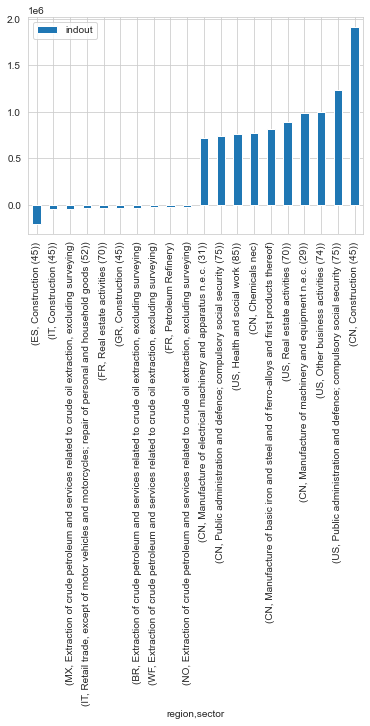

In [117]:
(data[2016]['x'] - data[2006]['x']).sort_values(by='indout').iloc[list(range(0,10))+list(range(-10,0))].plot.bar(stacked=True)